# Chapter 19 - Hyperparameter Optimization

## 19.1. What is Hyperparameter Optimization?

Deep neural networks come with a large number of parameters or weights that are learned during training. Additionally, every neural network has *hyperparameters* that need to be configured by the users. However, these hyperparameters cannot by adjusted by minimizing the training loss, because this would lead to overfitting on the training data.

*Hyperparameter optimization* (HPO) algorithms are designed to tackle this issue in a principled and automated fashion, by framing it as a global optimization problem. The default objective is the error on a hold-out validation dataset, but could in principle be any other business metric. It can be combined with or constrained by secondary objectives, such as training time, inference time, or model complexity.

Hyperparameter optimization also extends to *neural architecture search* (NAS), where the goal is to find entirely new neural network architectures. Both, HPO and NAS can be considered as sub-fields of AutoML, which aims to automate the entire ML pipeline.

### 19.1.1. The Optimization Problem

As an example, the toy problem here is to search for the leraning rate of the multi-class logistic regression model `SoftmaxRegression` to minimize the validation error on the Fashion-MNIST dataset.

In [1]:
import numpy as np
import torch
from scipy import stats
from torch import nn

from d2l import torch as d2l

#### 19.1.1.1. The Objective Function

The performance of a learning algorithm can be seen as a function $f: \mathcal{X} \rightarrow \mathbb{R}$ that maps from the hyperparameter space $\mathbf{x}\in\mathcal{X}$ to the validation loss. For every evaluation of $f(\mathbf{x})$, we have to train and validate the machine learning model, which can be time and compute intensive in the case of deep neural networks trained on large datasets. Given the criterion $f(\mathbf{x})$, the goal is to find $\mathbf{x}_{\star} \in \mathrm{argmin}_{\mathbf{x} \in \mathcal{X}} f(\mathbf{x})$.

The training of neural networks is stochastic (e.g., weights are randomly initialized, mini-batches are randomly sampled), so that our observations will be noisy: $y \sim f(\mathbf{x}) + \epsilon$, where we usually assume that $\epsilon \sim N(0, \sigma)$ the observation noise is Gaussian distributed.

We start with a method for computing the validation error of a model.

In [2]:
class HPOTrainer(d2l.Trainer):
    def validation_error(self):
        # set model to evaluation mode
        self.model.eval()

        accuracy = 0.
        val_batch_idx = 0

        for batch in self.val_dataloader:
            with torch.no_grad():
                x, y = self.prepare_batch(batch)
                y_hat = self.model(x)
                accuracy += self.model.accuracy(y_hat, y)

            val_batch_idx += 1

        val_err = 1 - accuracy / val_batch_idx

        return val_err

We use the `hpo_objective_softmax_classification` function to optimize validation error with respect to the hyperparameter configuration `config`, consisting of the `learning_rate`. For each evaluation, we train the model for `max_epochs` epochs, then compute and return its validation error:

In [3]:
def hpo_objective_softmax_classification(config, max_epochs=10):
    '''Objective function for hyperparameter optimization with softmax
    
    Parameters
    ----------
    config : dict
        Dictionary containing the hyperparameters to be optimized
    max_epochs : int
        Maximum number of epochs to train for
    
    Returns
    -------
    float
        Validation error of the trained model
    '''
    learning_rate = config['learning_rate']
    # create a trainer
    trainer = d2l.HPOTrainer(max_epochs=max_epochs)
    # load data
    data = d2l.FashionMNIST(batch_size=16)
    # create model
    model = d2l.SoftmaxRegression(num_outputs=10, lr=learning_rate)

    # train model
    trainer.fit(model=model, data=data)

    return trainer.validation_error().detach().numpy()

#### 19.1.1.2. The Configuration Space

Along with the objective function $f(\mathbf{x})$, we also need to define the feasible set $\mathbf{x}\in\mathcal{X}$ to optimize over, known as *configuration space* or *search space*.

In [4]:
config_space = {
    'learning_rate': stats.loguniform(1e-4, 1)
}

The `loguniform` function from `scipy` represents a uniform distribution between -4 to -1 in the log space.

Each hyperparameter has a data type, such as `float` for `learning_rate`, as well as a closed bounded range (i.e., lower and upper bounds). We usually assign a prior distribution (e.g., uniform or log-uniform) to each hyperparameter to sample from.

We will use the following table as our configuration space:

| Name | Type | Hyperparameter Ranges | log-scale |
| --- | --- | --- | --- |
| learning rate | float | $[10^{-6}, 10^{-1}]$ | yes |
| batch size | integer | $[8, 256]$ | yes |
| momentum | float | $[0.0, 0.99]$ | no |
| activation function | categorical | $\{\mathrm{tanh}, \mathrm{ReLU}\}$ |  |
| number of layers | integer | $[1, 6]$ | no |

The configuration space plays an important role for hyperparameter optimization, since no algorithms can find something that is not included in the configuration space. On the other hand, if the ranges are too large, the computation budget to find well performing configurations might become infeasible.

### 19.1.2. Random Search

The main idea of *random search* is to independently sample from the configuration space until a predefined budget (e.g., maximum number of iterations) is exhausted, and to return the best observed configuration. All evaluations can be executed independently in parallel.

    validation_error = 0.1711999773979187


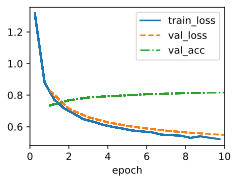

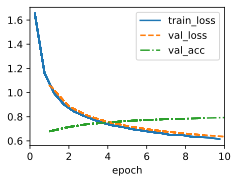

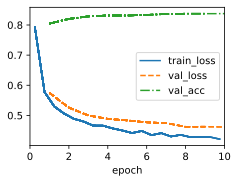

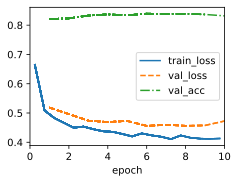

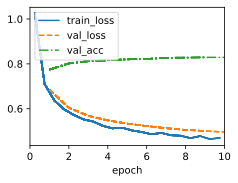

In [5]:
errors = []
values = []
num_iterations = 5

for i in range(num_iterations):
    # rvs() returns a random value from the loguniform distribution
    learning_rate = config_space['learning_rate'].rvs()
    print(f'Trial {i}: learning_rate = {learning_rate}')

    y = hpo_objective_softmax_classification({'learning_rate': learning_rate})
    print(f'    validation_error = {y}')
    values.append(learning_rate)
    errors.append(y)

The best learning rate is the one with the lowest validation error.

In [6]:
best_idx = np.argmin(errors) # index of the smallest error
best_lr = values[best_idx] # best learning rate
print(f'Optimal learning rate: {best_lr}')

Optimal learning rate: 0.012134049739080017


Due to its simplicity and generality, random search is one of the most frequently used HPO algorithms. It does not require any sophisticated implementation and can be applied to any configuration space as long as we can define some probability distribution for each hyperparameter.

## 19.2. Hyperparameter Optimization API

All HPO algoirthms need to implement two decision making primitives, *searching* and *scheduling*.
* Searching is to sample new hyperparameter configurations, which involves some search over the configuration space.
* Scheduling is to decide how many resources to allocate to each configuration.

Once we start to evaluate a configuration, we refer to it as a *trial*. We map these decisions to two classes: `HPOSearcher` and `HPOScheduler`. Besides that, we also provide a `HPOTuner` class that executes the optimization process.

This concept of scheduler and searcher is also implemented in Syne Tune, Ray Tune, or Optuna.

In [7]:
import time
from scipy import stats

from d2l import torch as d2l

### 19.2.1. Searcher